# PIV Basics (Modelling explained)

This notebook tries to explain how the PIV images are created and why. It shows this by practical examples.

## Particle Sizes

We need to distinguish between *physical (real) particles sizes* (e.g. in $\mu m$) and *image particle size* (on the sensor, in pixels).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger('synpivimage')
logger.setLevel('ERROR')

In [2]:
wavelength = 532*10**-9  # 513 nm, e.g. by Nd:YAG laser

def compute_d_diff(M, fnumber, wl=532*10**-9):
    """
    Diffraction limited minimum image diameter (d_diff). Independend of actual particle size, however, small enough to be considered a point source.
    
    M: optical magnification [-]
    fnumber: focal number, e.g. 2.8, 4.0, 5.6, 8.0, 11 [-]
    """
    return 2.44*fnumber*(M+1)*wl  # diffraction limited image diameter

def compute_d_tau(M, dp, fnumber):
    """See eq. 2.14 in Raffel et al."""
    return np.sqrt((M*dp)**2+compute_d_diff(M, fnumber)**2)

Note, that if the particle size is considerably larger than the wavelength ($d_\tau \gt \gt \lambda$, where Mie's theory applies), then the diffraction limit becomes less important while the image diameter increases almost linearly:

In [3]:
# diffraction limited diameter for M=0.1, f#=4 and wavelength=500:
compute_d_diff(0.1, 4, wl=500*10**-9)

5.368000000000001e-06

In [4]:
dp=5*10**-6  # 5 mu
0.1*dp

5e-07

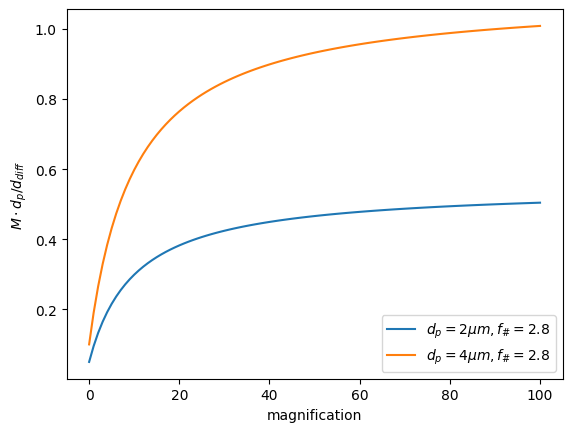

In [5]:
plt.figure()
magnifications = np.linspace(0.1, 11, 101)

ddiff = compute_d_diff(M=magnifications, fnumber=2.8)
dopt = magnifications*2*10**-6
plt.plot(dopt/ddiff, label='$d_p=2 \mu m, f_\#=2.8$')

ddiff = compute_d_diff(M=magnifications, fnumber=2.8)
dopt = magnifications*4*10**-6
plt.plot(dopt/ddiff, label='$d_p=4 \mu m, f_\#=2.8$')
# plt.ylim([0, 1])
# plt.plot(magnifications, compute_d_diff(M=magnifications, fnumber=2.8)*10**6, label='$d_{diff}$')
# plt.plot(magnifications, compute_d_tau(M=magnifications, dp=1*10**-6, fnumber=2.8)*10**6, label='$d_\\tau$ ($d_p=1 \mu m$)')
# plt.plot(magnifications, compute_d_tau(M=magnifications, dp=5*10**-6, fnumber=2.8)*10**6, label='$d_\\tau$ ($d_p=5 \mu m$)')
plt.xlabel('magnification')
plt.ylabel('$M \cdot d_p/d_{diff}$')
plt.legend()
plt.show()

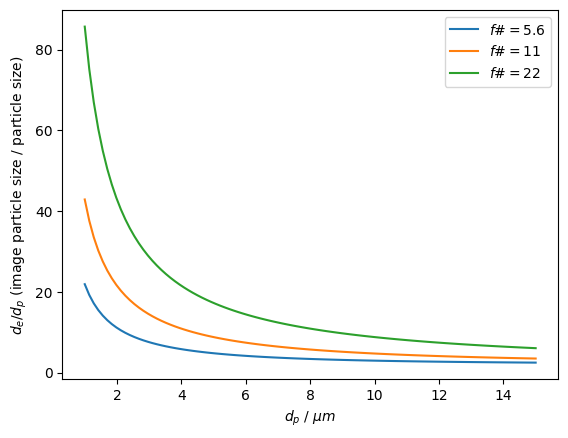

In [6]:
plt.figure()
dps = np.linspace(1, 15, 101)*10**-6
plt.plot(dps*10**6, compute_d_tau(M=2, dp=dps, fnumber=5.6)/dps, label='$f\# = 5.6$')
plt.plot(dps*10**6, compute_d_tau(M=2, dp=dps, fnumber=11)/dps, label='$f\# = 11$')
plt.plot(dps*10**6, compute_d_tau(M=2, dp=dps, fnumber=22)/dps, label='$f\# = 22$')
plt.xlabel('$d_p$ / $\mu m$')
plt.ylabel('$d_e$/$d_p$ (image particle size / particle size)')
plt.legend()
plt.show()

### Definition of the image particle size
The image particle size is simulated by a Gaussian distribution. Various definitions can be found in publications. Some define the size as $d=2 \cdot \sigma$ (it is unclear if the radius or the diameter is meant though), others like the PIV book define it where the intensity drops to $e^{-2}$, which is $4 \sigma$. Others like the Synthetic Particle Generator (SIG) by Lecordier use $I_0/2$ as the particle width.

We will stick to the $e^{-2}$ definition, thus a image particle diameter is $4 \sigma$.

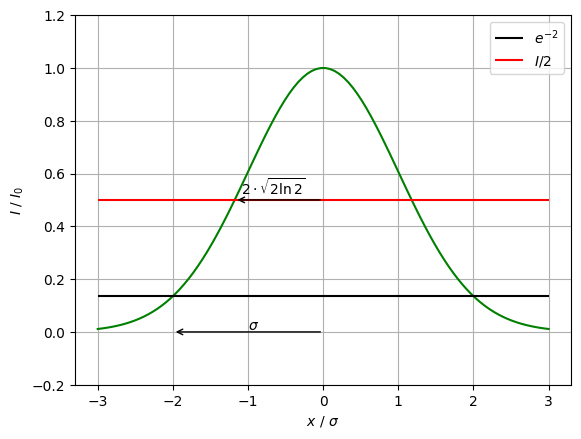

In [7]:
def gauss(x, I0, sigma):
    return I0*np.exp(-x**2/(2*sigma**2))

sigma = 2
x = np.linspace(-sigma*3, sigma*3, 100)
plt.figure()
plt.plot(x/sigma, gauss(x, 1, sigma=sigma), color='g')
plt.hlines(np.exp(-2), x[0]/sigma, x[-1]/sigma, color='k', label='$e^{-2}$')
plt.hlines(0.5, x[0]/sigma, x[-1]/sigma, color='r', label='$I/2$')
# plt.vlines(-np.sqrt(2*np.log(2))*2/sigma,0,1, label='$2 \cdot \sqrt{2 \ln 2}$')  # from Lecordier
# plt.vlines(-sigma,0,1, color='y', label='$\sigma$')  # from Lecordier
# plt.vlines(-sigma/2,0,1, linestyle='--', color='y', label='$\sigma /2 $')  # from Lecordier
# plt.arrow(0,0,-sigma,0, head_width=0.05, length_includes_head=True, color='k', )

plt.gca().annotate("", xy=(-sigma, 0), xytext=(0, 0),
                   arrowprops=dict(arrowstyle="->"))
plt.text(-1, 0.01, '$\sigma$')

plt.gca().annotate("", xy=(-np.sqrt(2*np.log(2))*2/sigma, 0.5), xytext=(0, 0.5),
                   arrowprops=dict(arrowstyle="->"))
plt.text(-np.sqrt(2*np.log(2))*2/sigma+0.08, 0.52, '$2 \cdot \sqrt{2 \ln 2}$')

plt.xlabel('$x~/~\sigma$')
plt.ylabel('$I~/~I_0$')
plt.legend()
plt.ylim(-0.2, 1.2)
plt.grid()
plt.show()



In [8]:
from synpivimage import take_image, Camera, Laser, Particles

## Effective image particle size

Dependent on the fill ratio, the particle size appears smaller. Let's examine the behavior by generating a single particle without any noise for various fill ratios:

In [9]:
cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=50,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2
)
cam.save('my_cam.json')

laser = Laser(
    width=0.25,
    shape_factor=1002
)

particles = Particles(
    x=8,
    y=8,
    z=0,
    size=2
)
particles.x

array([8])

In [10]:
imgA, partA = take_image(laser, cam, particles, particle_peak_count=1000, debug_level=0)

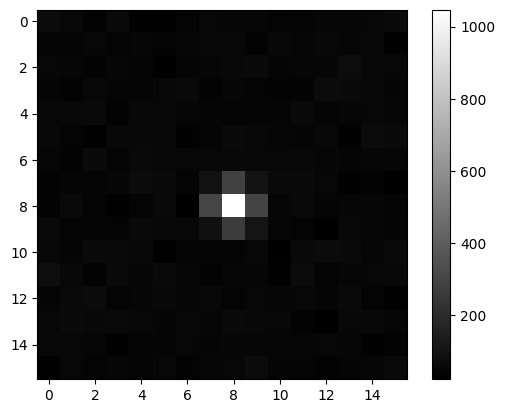

In [11]:
plt.figure()
plt.imshow(imgA, cmap='gray')
plt.colorbar()

In [12]:
cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=0,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2
)
cam.save('my_cam.json')

laser = Laser(
    width=1.0,
    shape_factor=10**3
)

particles = Particles(
    x=8,
    y=8,
    z=0,
    size=2
)

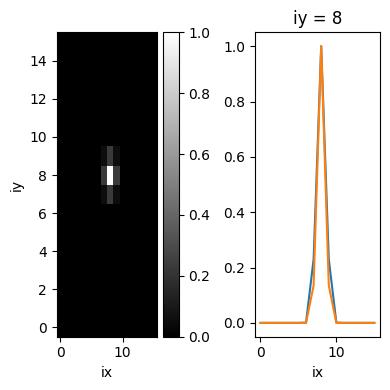

In [13]:
from synpivimage.plotting import imshow

imgA1, partA1 = take_image(laser=laser,
                   cam=cam,
                   particles=particles,
                   particle_peak_count=1000)

fig, axs = plt.subplots(1, 2, figsize=(4,4), tight_layout=True)

imgA1n = imgA1.normalize().asxarray()
imgA1n[:].plot(ax=axs[0], cmap='gray')
slice = imgA1n[8, :]
slice.plot(ax=axs[1])

cam.fill_ratio_x = 0.01
cam.fill_ratio_y = 0.01

imgA1, partA1 = take_image(laser=laser,
                   cam=cam,
                   particles=particles,
                   particle_peak_count=1000)

imgA1n = imgA1.normalize().asxarray()

slice = imgA1n[8, :]
slice.plot(ax=axs[1])

plt.show()

In [14]:
import synpivimage

In [15]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

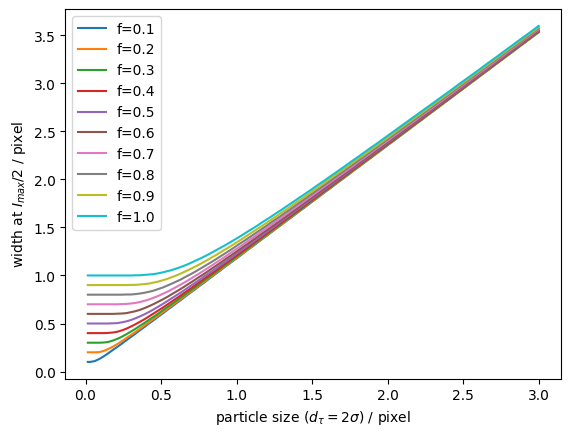

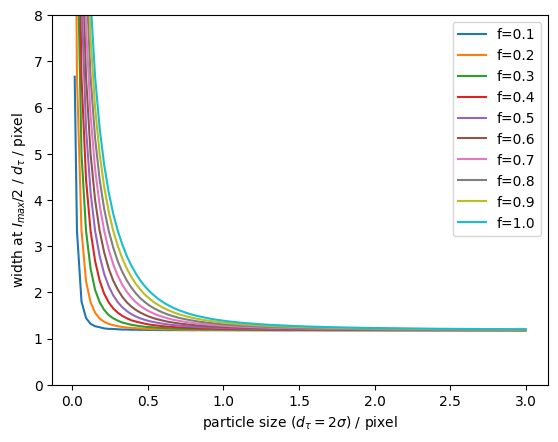

In [16]:
x = np.linspace(-5, 5, 10001)

partice_widths = np.linspace(0, 3, 101)
partice_widths[0] = (partice_widths[1]+partice_widths[0])/2


plt.figure()
for fr in np.arange(0.1, 1.1, 0.1):
    I2x = []
    for pwidth in partice_widths:
        sigma = pwidth / 2 # per definition
        y = synpivimage.particles.compute_intensity_distribution(x,0,0,0,dp=1,
                                                          sigmax=sigma,
                                                          sigmay=sigma,
                                                          fill_ratio_x=fr,fill_ratio_y=fr)
        ynorm = y/y.max()
        imin = np.argmin(np.abs(ynorm-0.5))
        # plt.plot(x, ynorm)

        sigma_extracted = np.abs(x[imin])
        particle_size_I2 = 2*sigma_extracted
        
        I2x.append(particle_size_I2)
        
        # plt.scatter(np.abs(x[imin]), ynorm[imin])
    
    plt.plot(partice_widths, I2x, label=f'f={fr:0.1f}')
plt.xlabel('particle size ($d_\\tau = 2\sigma$) / pixel')
plt.ylabel('width at $I_{max}/2$ / pixel')
plt.legend()
plt.show()

plt.figure()
for fr in np.arange(0.1, 1.1, 0.1):
    I2x = []
    for pwidth in partice_widths:
        sigma = pwidth / 2 # per definition
        y = synpivimage.particles.compute_intensity_distribution(x,0,0,0,dp=1,
                                                          sigmax=sigma,
                                                          sigmay=sigma,
                                                          fill_ratio_x=fr,fill_ratio_y=fr)
        ynorm = y/y.max()
        imin = np.argmin(np.abs(ynorm-0.5))

        sigma_extracted = np.abs(x[imin])
        particle_size_I2 = 2*sigma_extracted
        
        I2x.append(particle_size_I2)
    
    plt.plot(partice_widths, I2x/partice_widths, label=f'f={fr:0.1f}')
plt.xlabel('particle size ($d_\\tau = 2\sigma$) / pixel')
plt.ylabel('width at $I_{max}/2~/~d_{\\tau}$ / pixel')
plt.ylim([0, 8])
plt.legend()
plt.show()

# Simple(st) single particle

No noise, just one particle in the middle of the image.

The particle images are simulated using a gaussian distribution (bell curve). The width of a particle image intensity is defined by $2\sigma$. Note, that this size depends on the optical setup (magnification, aperture). You can define the particle image width using `pattern_meanx` and `pattern_meany` (yes, theoretically you can have skewed particles). It is important to understand, that the particle (mean) size, defined via `particle_size_mean`, is

In [17]:
cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=0,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2
)
# cam.save('my_cam.json')

laser = Laser(
    width=1.0,
    shape_factor=10**3
)

density = 0.1
gny, gnx = cam.ny+20, cam.nx+20
n = int(density*gny*gnx)

particles = Particles(
    x=np.random.uniform(-10, cam.nx+10, n),
    y=np.random.uniform(-10, cam.ny+10, n),
    z=np.zeros(n),
    size=np.ones(n)*2
)

particles = Particles(
    x=np.random.uniform(-10, cam.nx+10, n),
    y=np.random.uniform(-10, cam.ny+10, n),
    z=np.zeros(n),
    size=np.ones(n)*2
)

In [20]:
imgA1, partA1 = take_image(cam=cam,
                   laser=laser,
                   particle_peak_count=1000,
                   particles=particles)
particlesB = particles.copy()
particlesB.displace(dx=2)
imgB1, partB1 = take_image(cam=cam,
                   laser=laser,
                   particle_peak_count=1000,
                   particles=particlesB)

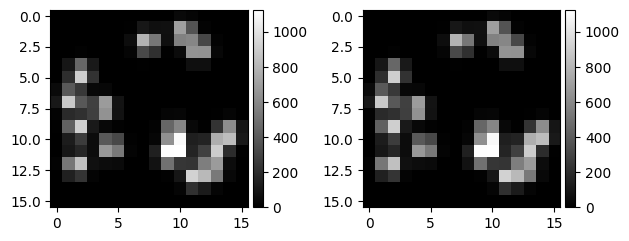

In [21]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
ax, _, _ = imshow(imgA1, ax=axs[0])
# ax.set_title(f'{meta1["particle_size_definition"]}\npart size: {partinfo1.size[0]} px\npart std: {meta1["sigmax"]} px')

ax, _, _ = imshow(imgB1, ax=axs[1])
# ax.set_title(f'{meta2["particle_size_definition"]}\npart size: {partinfo2.size[0]} px\npart std: {meta2["sigmax"]} px')

plt.show()

In [22]:
import matplotlib.pyplot as plt
import numpy as np

Let's check the distribution in 1D. According to Lecordier, the image size is defined at location where $I=I_0/2$. As we set 3 as the particle width, let's normalize the x-axis accordingy:

2.0


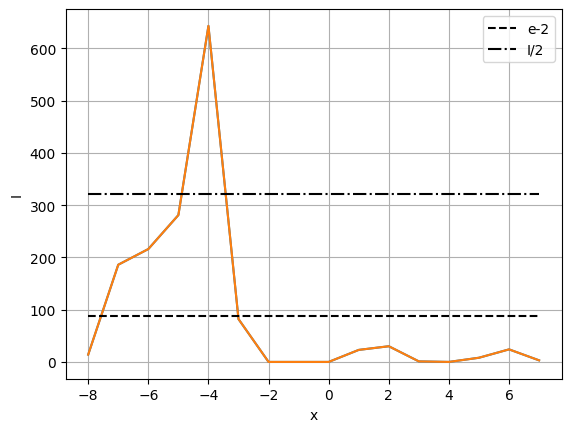

In [23]:
x = np.arange(0, 16, 1)-8

dp = cam.particle_image_diameter
print(dp)

_x = x#/(dp/2)
plt.plot(_x, imgA1[8,:])
plt.plot(_x, imgB1[8,:])
plt.hlines(np.exp(-2)*imgA1[8,:].max(), _x[0], _x[-1], color='k', linestyles='--', label='e-2')
plt.hlines(imgA1[8,:].max()/2, _x[0], _x[-1], color='k', linestyles='-.', label='I/2')
plt.xlabel('x')
plt.ylabel('I')
plt.legend()
plt.grid()